# Learning more on Octupoles and GPU programming

We want to study what happens the strange behaviours that appear when switching the octupoles on and off.
But first we need to understand how to program on GPUs.
XSuite makes it simpler for us but with some tweaks that need to be understood.

In [1]:
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
import json
import pandas as pd
from cpymad.madx import Madx
from matplotlib import pyplot as plt
%matplotlib inline
import NAFFlib

If the GPU is an NVDIA then we can use Cupy.

In [2]:
ctx = xo.ContextCupy()

Run 3 lattice with knobs activated.

In [3]:
mad = Madx()
mad.call('andrea.madx')
mad.use(sequence="lhcb1")

GC Warning: Repeated allocation of very large block (appr. size 323584):
	May lead to memory leak and poor performance
GC Warning: Repeated allocation of very large block (appr. size 491520):
	May lead to memory leak and poor performance


In [5]:
#line.element_names
line = xt.Line.from_madx_sequence(mad.sequence['lhcb1'],
                                  deferred_expressions=True
                                  )

In [6]:
print(line.vars['i_mo']._get_value())
line.vars['i_mo'] = 0
print(line.vars['i_mo']._get_value())

-350.0
0


We need particles, let's define some. 
First of all we define the $\sigma_{x}$=$\sqrt{\frac{\beta_{x}\epsilon}{\gamma}}$, with $\epsilon=2\times10^{-6}$

In [7]:
gamma=7000/.938
sigma_x=np.sqrt(120.29057045*3e-6/gamma)
sigma_x

0.00021990181745701876

This particle will be used only to define the tracker, after this we'll use the Closed Orbit given by the tracker to keep track of what happens.

In [8]:
particles_3 = xp.Particles(_context=ctx,
                        p0c=7000e9,
                        x=[1.00951707e-08],px=[1.69518015e-10],
                        y=[5.65551848e-12],py=[6.07695199e-14]
                        )

In [9]:
tracker = xt.Tracker(_context=ctx, line=line)
tw = tracker.twiss(particles_3)

p0 will be our reference particle.

In [10]:
p0=tw['particle_on_co']
p0.x

array([0.])

Now we can define our particles starting from this one! The non explicit coordinates are set to zero.

In [11]:
particles = xp.build_particles(_context=ctx, particle_ref=p0, x=[p0.x+0.3*sigma_x,p0.x+0.6*sigma_x,p0.x+0.9*sigma_x,
                                                                 p0.x+1.2*sigma_x,p0.x+1.6*sigma_x,p0.x+2.0*sigma_x])

We can now print some of the particles variables

In [12]:
print(particles.x[0])
print(particles.x[5])
print(particles.p0c[2])
print(particles.zeta[3])
print(particles.y[4])

6.597054523710562e-05
0.00043980363491403753
7000000000000.0
0.0
0.0


Futhermore we can save the particles into a dictionary

In [13]:
dct = particles.to_dict()
#dct

Or into a **pandas** dataframe!

In [14]:
my_df = particles.to_pandas()
my_df

,q0,mass0,p0c,gamma0,beta0,s,x,y,px,py,...,state,parent_particle_id,_rng_s1,_rng_s2,_rng_s3,_rng_s4,delta,psigma,rvv,rpp
0,1.0,9.382721e+08,7.000000e+12,7460.522541,1.0,0.0,0.000066,0.0,0.0,0.0,...,1,0,0,0,0,0,0.0,0.0,1.0,1.0
1,1.0,9.382721e+08,7.000000e+12,7460.522541,1.0,0.0,0.000132,0.0,0.0,0.0,...,1,1,0,0,0,0,0.0,0.0,1.0,1.0
2,1.0,9.382721e+08,7.000000e+12,7460.522541,1.0,0.0,0.000198,0.0,0.0,0.0,...,1,2,0,0,0,0,0.0,0.0,1.0,1.0
3,1.0,9.382721e+08,7.000000e+12,7460.522541,1.0,0.0,0.000264,0.0,0.0,0.0,...,1,3,0,0,0,0,0.0,0.0,1.0,1.0
4,1.0,9.382721e+08,7.000000e+12,7460.522541,1.0,0.0,0.000352,0.0,0.0,0.0,...,1,4,0,0,0,0,0.0,0.0,1.0,1.0
5,1.0,9.382721e+08,7.000000e+12,7460.522541,1.0,0.0,0.000440,0.0,0.0,0.0,...,1,5,0,0,0,0,0.0,0.0,1.0,1.0


Now we need to access the variables to plot them, since these are stored into the GPU we need to do the following (particles_x is just a name, you can call it as you like).

In [15]:
particles_x = ctx.nparray_from_context_array(particles.x)
particles_px = ctx.nparray_from_context_array(particles.px)
particles_y = ctx.nparray_from_context_array(particles.y)
particles_py = ctx.nparray_from_context_array(particles.py)
particles_zeta = ctx.nparray_from_context_array(particles.zeta)
particles_delta = ctx.nparray_from_context_array(particles.delta)

Time to track!

In [16]:
tracker = xt.Tracker(_context=ctx, line=line)
tw = tracker.twiss(particles_3)
N=100
#I'm tracking 6 particles in this case
N_particles=6
n_turns=1

x = [[0 for turns in range(N)] for protons in range(N_particles)] 
px = [[0 for turns in range(N)] for protons in range(N_particles)] 
y = [[0 for turns in range(N)] for protons in range(N_particles)] 
py = [[0 for turns in range(N)] for protons in range(N_particles)] 
zeta = [[0 for turns in range(N)] for protons in range(N_particles)] 
delta = [[0 for turns in range(N)] for protons in range(N_particles)] 

for ii in range(N):
    tracker.track(particles, num_turns=n_turns,turn_by_turn_monitor=False)
    for jj in range(N_particles):
        x[jj][ii] = ctx.nparray_from_context_array(particles.x)[jj]
        px[jj][ii] = ctx.nparray_from_context_array(particles.px)[jj]
        y[jj][ii] = ctx.nparray_from_context_array(particles.y)[jj]
        py[jj][ii] = ctx.nparray_from_context_array(particles.py)[jj]
        zeta[jj][ii] = ctx.nparray_from_context_array(particles.zeta)[jj]
        delta[jj][ii] = ctx.nparray_from_context_array(particles.delta)[jj]

In [17]:
#for ii in range(N):
    #print(x[5][ii])

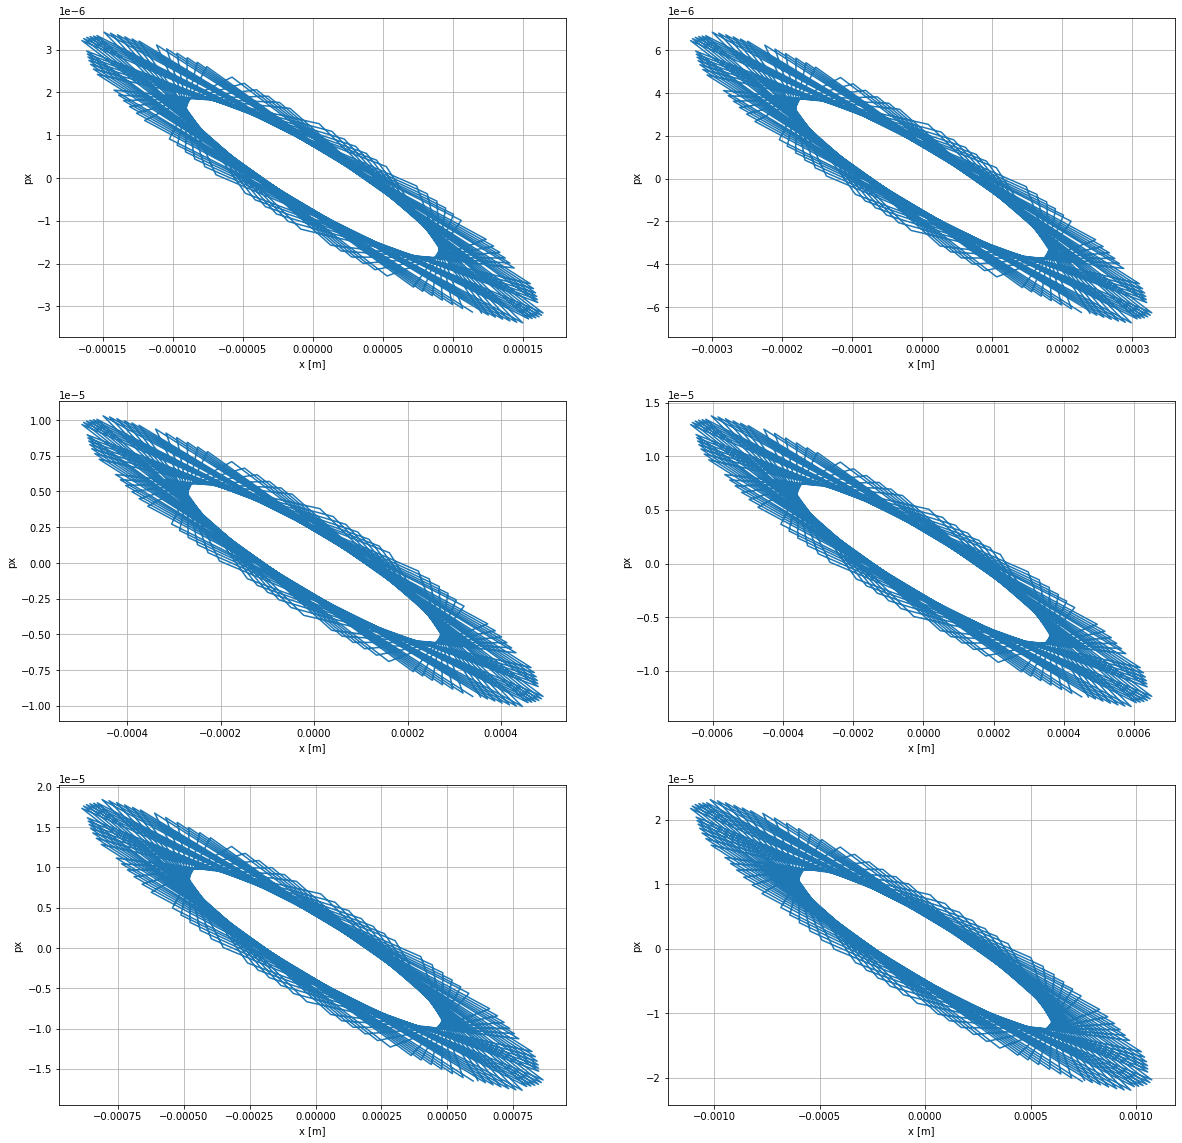

In [18]:
fig1 = plt.figure(1, figsize=(20, 20))

xtransverse1 = plt.subplot(3,2,1)
xtransverse1.plot(x[0], px[0])
xtransverse1.set_xlabel('x [m]')
xtransverse1.set_ylabel('px')
xtransverse1.grid()

xtransverse2 = plt.subplot(3,2,2)
xtransverse2.plot(x[1], px[1])
xtransverse2.set_xlabel('x [m]')
xtransverse2.set_ylabel('px')
xtransverse2.grid()

xtransverse3 = plt.subplot(3,2,3)
xtransverse3.plot(x[2], px[2])
xtransverse3.set_xlabel('x [m]')
xtransverse3.set_ylabel('px')
xtransverse3.grid()

xtransverse4 = plt.subplot(3,2,4)
xtransverse4.plot(x[3], px[3])
xtransverse4.set_xlabel('x [m]')
xtransverse4.set_ylabel('px')
xtransverse4.grid()

xtransverse5 = plt.subplot(3,2,5)
xtransverse5.plot(x[4], px[4])
xtransverse5.set_xlabel('x [m]')
xtransverse5.set_ylabel('px')
xtransverse5.grid()

xtransverse6 = plt.subplot(3,2,6)
xtransverse6.plot(x[5], px[5])
xtransverse6.set_xlabel('x [m]')
xtransverse6.set_ylabel('px')
xtransverse6.grid()

plt.show()

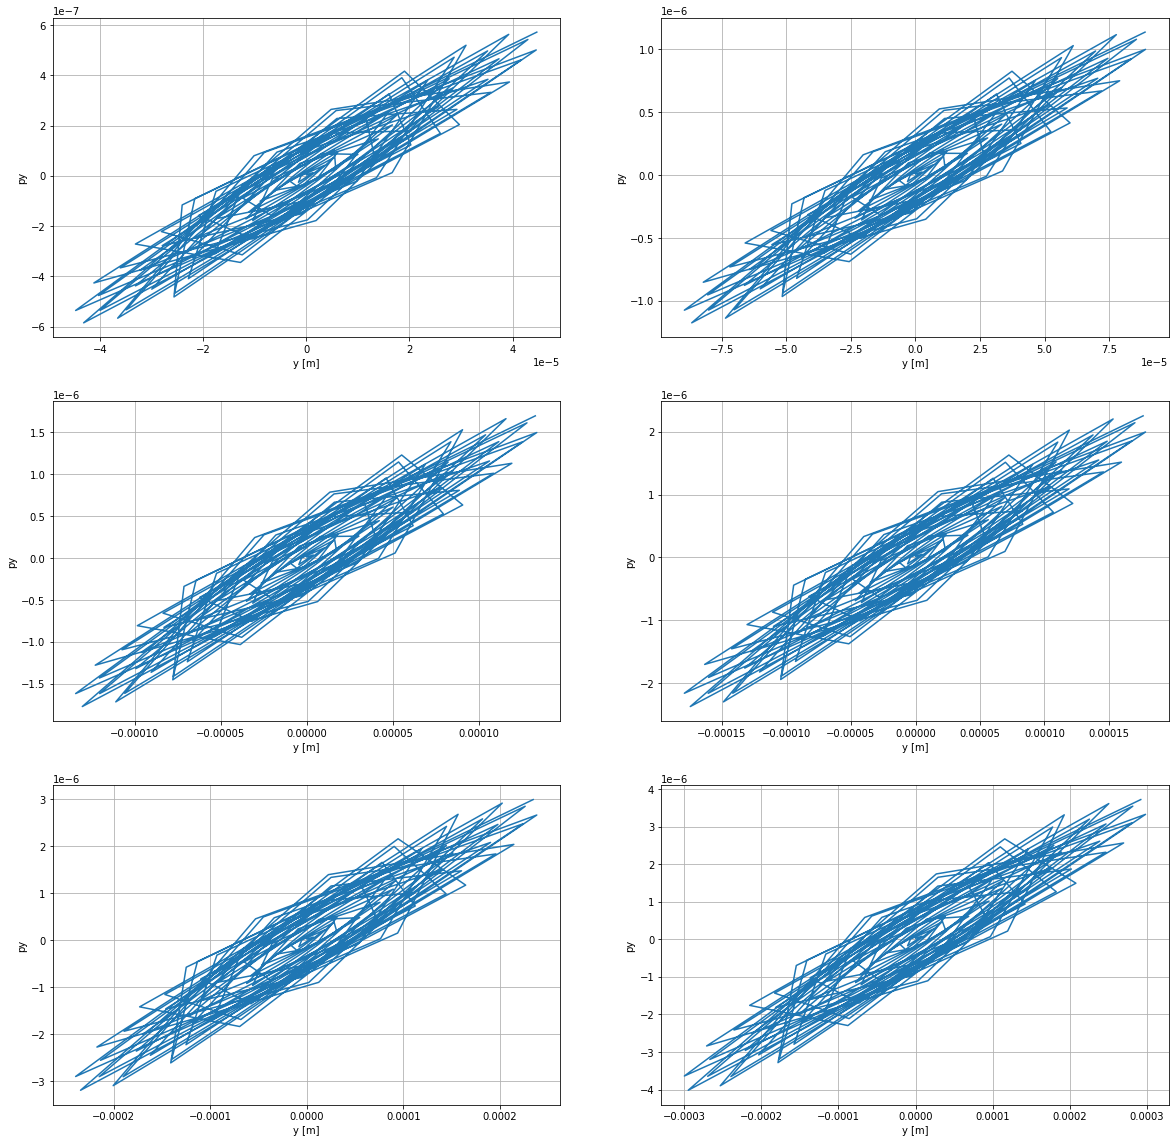

In [19]:
fig1 = plt.figure(1, figsize=(20, 20))

ytransverse1 = plt.subplot(3,2,1)
ytransverse1.plot(y[0], py[0])
ytransverse1.set_xlabel('y [m]')
ytransverse1.set_ylabel('py')
ytransverse1.grid()

ytransverse2 = plt.subplot(3,2,2)
ytransverse2.plot(y[1], py[1])
ytransverse2.set_xlabel('y [m]')
ytransverse2.set_ylabel('py')
ytransverse2.grid()

ytransverse3 = plt.subplot(3,2,3)
ytransverse3.plot(y[2], py[2])
ytransverse3.set_xlabel('y [m]')
ytransverse3.set_ylabel('py')
ytransverse3.grid()

ytransverse4 = plt.subplot(3,2,4)
ytransverse4.plot(y[3], py[3])
ytransverse4.set_xlabel('y [m]')
ytransverse4.set_ylabel('py')
ytransverse4.grid()

ytransverse5 = plt.subplot(3,2,5)
ytransverse5.plot(y[4], py[4])
ytransverse5.set_xlabel('y [m]')
ytransverse5.set_ylabel('py')
ytransverse5.grid()

ytransverse6 = plt.subplot(3,2,6)
ytransverse6.plot(y[5], py[5])
ytransverse6.set_xlabel('y [m]')
ytransverse6.set_ylabel('py')
ytransverse6.grid()

plt.show()

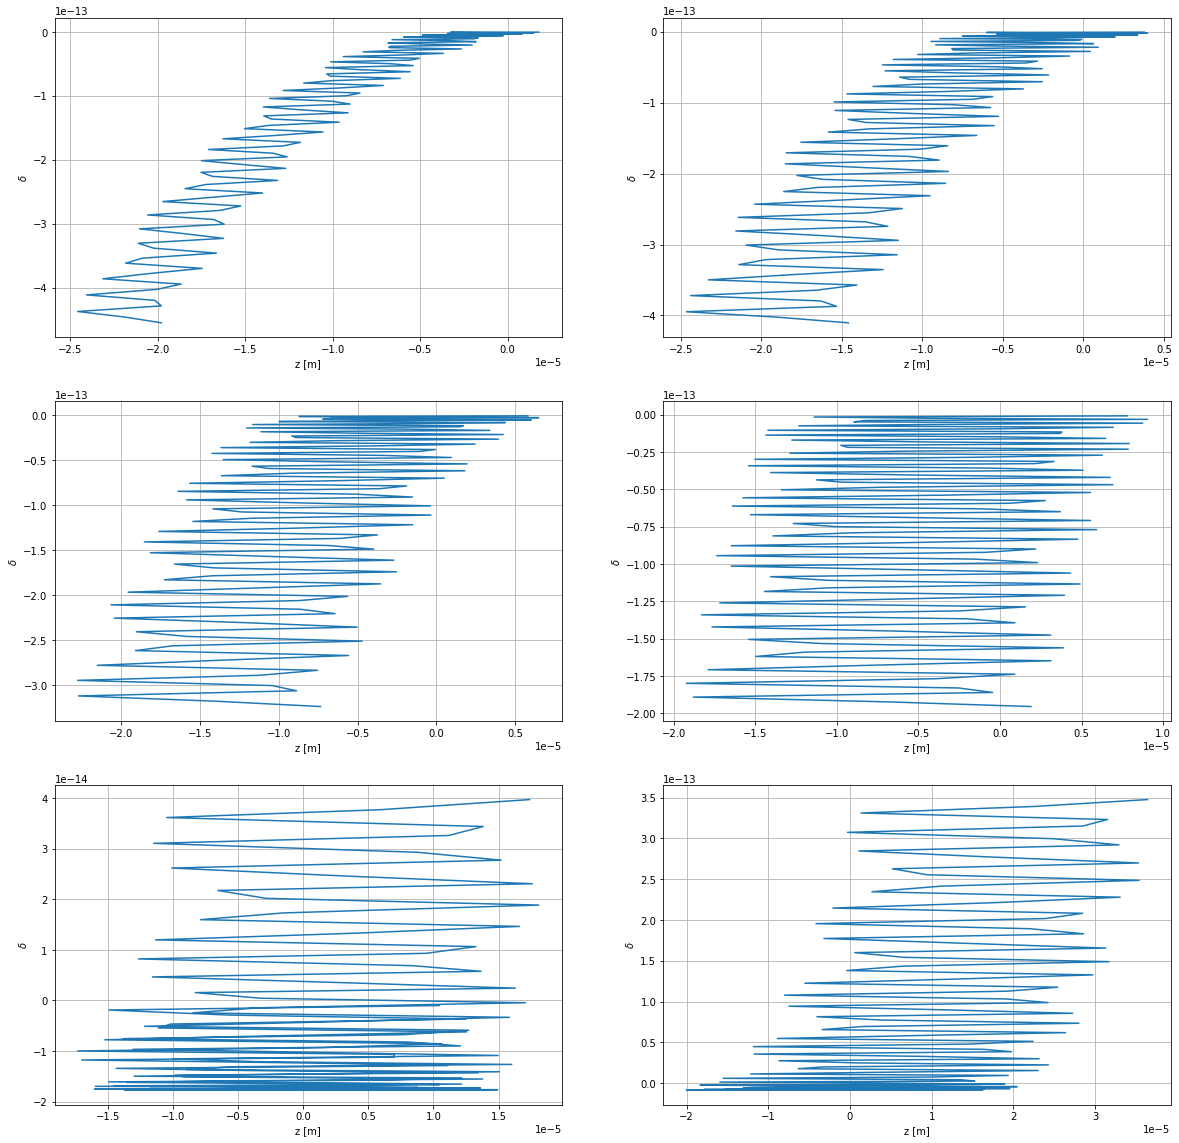

In [20]:
fig1 = plt.figure(1, figsize=(20, 20))

ztransverse1 = plt.subplot(3,2,1)
ztransverse1.plot(zeta[0], delta[0])
ztransverse1.set_xlabel('z [m]')
ztransverse1.set_ylabel('$\delta$')
ztransverse1.grid()

ztransverse2 = plt.subplot(3,2,2)
ztransverse2.plot(zeta[1], delta[1])
ztransverse2.set_xlabel('z [m]')
ztransverse2.set_ylabel('$\delta$')
ztransverse2.grid()

ztransverse3 = plt.subplot(3,2,3)
ztransverse3.plot(zeta[2], delta[2])
ztransverse3.set_xlabel('z [m]')
ztransverse3.set_ylabel('$\delta$')
ztransverse3.grid()

ztransverse4 = plt.subplot(3,2,4)
ztransverse4.plot(zeta[3], delta[3])
ztransverse4.set_xlabel('z [m]')
ztransverse4.set_ylabel('$\delta$')
ztransverse4.grid()

ztransverse5 = plt.subplot(3,2,5)
ztransverse5.plot(zeta[4], delta[4])
ztransverse5.set_xlabel('z [m]')
ztransverse5.set_ylabel('$\delta$')
ztransverse5.grid()

ztransverse6 = plt.subplot(3,2,6)
ztransverse6.plot(zeta[5], delta[5])
ztransverse6.set_xlabel('z [m]')
ztransverse6.set_ylabel('$\delta$')
ztransverse6.grid()

plt.show()

In [ ]:

#Scorrere sugli ottupoli
sum_nl = 0.0
count_nl = 0
sum_sl = 0.0
count_sl = 0
for elem in line.element_dict :
    if isinstance(line.element_dict[elem],xt.beam_elements.elements.Multipole):   
        if(line.element_dict[elem].order==3):
                #i print sono giusti, li commento perché sono lunghi
                sum_nl+=line.element_dict[elem].knl[3]
                count_nl+=1
                sum_sl+=line.element_dict[elem].ksl
                count_sl+=1
                #print(elem)
                #print(line.element_dict[elem].knl)
                
        if(line.element_dict[elem].order==2):
                #i print sono giusti, li commento perché sono lunghi
                sum_nl+=line.element_dict[elem].knl[2]
                count_nl+=1
                #print(elem)
                #print(line.element_dict[elem].knl)
K_OCT = sum_nl/count_nl
K_OCT

In [ ]:
particles_3 = xp.Particles(_context=ctx,
                        p0c=7000e9,
                        x=[1.00951707e-08],px=[1.69518015e-10],
                        y=[5.65551848e-12],py=[6.07695199e-14]
                        )

In [ ]:
tracker1 = xt.Tracker(_context=ctx, line=line)
tw1 = tracker1.twiss(particles_3)
tracker2 = xt.Tracker(_context=ctx, line=line)
tw2 = tracker2.twiss(particles_3)
tracker3 = xt.Tracker(_context=ctx, line=line)
tw3 = tracker3.twiss(particles_3)
tracker4 = xt.Tracker(_context=ctx, line=line)
tw4 = tracker4.twiss(particles_3)
tracker5 = xt.Tracker(_context=ctx, line=line)
tw5 = tracker5.twiss(particles_3)

In [ ]:
gamma=7000/.938
sigma_x=np.sqrt(120.29057045*3e-6/gamma)
sigma_x
n_turns = 1
N_arr=10000
#x_part0 = np.zeros(N_arr)
x_part1 = np.zeros(N_arr)
x_part2 = np.zeros(N_arr)
x_part3 = np.zeros(N_arr)
x_part4 = np.zeros(N_arr)
x_part5 = np.zeros(N_arr)

#co_part=tw['particle_on_co']
near_co_particle1=tw1['particle_on_co']
near_co_particle2=tw2['particle_on_co']
near_co_particle3=tw3['particle_on_co']
near_co_particle4=tw4['particle_on_co']
near_co_particle5=tw5['particle_on_co']


if False:
    for ii in range(N_arr):
        tracker.track(co_part, num_turns=n_turns,turn_by_turn_monitor=False)
        #print(particles_3.x)
        x_part0[ii]=co_part.x

positions = np.zeros(4)    
near_co_particle1.x=near_co_particle1.x+1e-5
near_co_particle2.x=near_co_particle2.x+1*sigma_x
near_co_particle3.x=near_co_particle3.x+2*sigma_x
near_co_particle4.x=near_co_particle4.x+3*sigma_x
near_co_particle5.x=near_co_particle5.x+4*sigma_x

positions[0]=near_co_particle2.x-near_co_particle1.x
positions[1]=near_co_particle3.x-near_co_particle1.x
positions[2]=near_co_particle4.x-near_co_particle1.x
positions[3]=near_co_particle5.x-near_co_particle1.x

if False:
    for ii in range(N_arr):
        tracker1.track(near_co_particle1, num_turns=n_turns,turn_by_turn_monitor=False)
        x_part1[ii]=near_co_particle1.x
        #print(x_part1[ii])
for ii in range(N_arr):
    tracker2.track(near_co_particle2, num_turns=n_turns,turn_by_turn_monitor=False)
    x_part2[ii]=near_co_particle2.x
    #print(x_part2[ii])
for ii in range(N_arr):
    tracker3.track(near_co_particle3, num_turns=n_turns,turn_by_turn_monitor=False)
    x_part3[ii]=near_co_particle3.x
    #print(x_part3[ii])
for ii in range(N_arr):
    tracker4.track(near_co_particle4, num_turns=n_turns,turn_by_turn_monitor=False)
    x_part4[ii]=near_co_particle4.x
for ii in range(N_arr):
    tracker5.track(near_co_particle5, num_turns=n_turns,turn_by_turn_monitor=False)
    x_part5[ii]=near_co_particle5.x
    #print(x_part5[ii])
    
#print(x_part1[ii])

In [ ]:
#Max_reco_freq= sampling frequency/2.
plt.figure()
#plt.plot(np.linspace(0,1,len(x_part0)), np.abs(np.fft.fft(x_part0)), 'b')
#plt.plot(np.linspace(0,1,len(x_part1)), np.abs(np.fft.fft(x_part1)), 'c')
plt.plot(np.linspace(0,1,len(x_part2)), np.abs(np.fft.fft(x_part2)), 'm')
plt.plot(np.linspace(0,1,len(x_part3)), np.abs(np.fft.fft(x_part3)), 'y')
plt.plot(np.linspace(0,1,len(x_part4)), np.abs(np.fft.fft(x_part4)), 'g')
plt.plot(np.linspace(0,1,len(x_part5)), np.abs(np.fft.fft(x_part5)), 'r')
plt.xlabel('Q1 from X')
plt.ylabel('FFT amplitude [arb. units]')
plt.xlim(0.312,0.314)
plt.grid()
#print(np.abs(np.fft.fft(x_part)))

In [ ]:
#q0 = NAFFlib.get_tune(x_part0)
q1 = NAFFlib.get_tune(x_part1)
q2 = NAFFlib.get_tune(x_part2)
q3 = NAFFlib.get_tune(x_part3)
q4 = NAFFlib.get_tune(x_part4)
q5 = NAFFlib.get_tune(x_part5)
print('q1 =',q1,'q2 =', q2, ', q3 =', q3, ', q4 =', q4,', q5 =', q5)
tunes = np.zeros(4)
#tunes[0]=q0
#tunes[0]=q1
tunes[0]=q2
tunes[1]=q3
tunes[2]=q4
tunes[3]=q5
#positions[0]=x_part0[0] 
#positions[0]=near_co_particle1.x+0.2*sigma_x

#print(positions[1],tunes[1])

In [ ]:
plt.plot(positions,tunes,'.')
plt.grid()
plt.xlabel('dx')
plt.ylabel('tunes');
#plt.ylim(0.312,0.315)